## Imports

In [1]:
!pip -q install numpy scipy matplotlib tensorflow==2.11.0 tensorflow-datasets==4.8.3 tensorflow-probability==0.19.0 deeptrack==1.5.5
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.2/186.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 34.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 51.2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import expon

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10836400172735015185
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15198191616
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15019479387180686972
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

## 1. Stimulus

In [3]:
# Parameters:
IMAGE_SIZE = 180

CR_SIGMA_RANGE = [1, 30]
GAUSS_AMPLITUDE_RANGE = [2, 20000]

NOISE_SD_RANGE = [0, 30]

BACKGROUND_LUM_EXP_LOC = 1.
BACKGROUND_LUM_EXP_SCALE = 10.
BG_LUMINANCE_RANGE = [.125, .6]

plt.rcParams['figure.figsize'] = [8, 8]


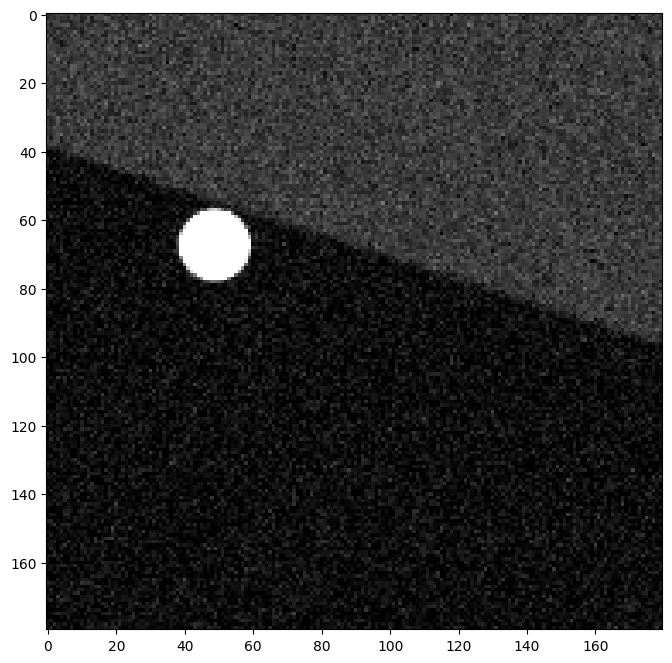

position: [48.85610322 67.31696972], gray_extent: None, cr_sigma: [10.19045703], gauss_amp: [12293.23792235], noise_sigma: [10.19045703]


In [7]:
def drawFromRange(range, n=1):
    # range - list of length 2, e.g., [1, 2]
    return range[0] + np.random.rand(n) * np.diff(range)

# inverse unnormalized Gaussian for scaling
def gauss1d_inv(v=0,mx=0,sx=1):
    return mx + np.sqrt(2)*sx*np.sqrt(-np.log(v))

# define 2D Gaussian (without normalization term so peak is 1)
def gauss2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

class GrayBackground(dt.Feature):
    __list_merge_strategy__ = dt.MERGE_STRATEGY_APPEND
    __distributed__ = False
    def get(self, image, pos, ori, lum, bg_lum, smooth_edge, **kwargs):
        x = np.arange(0, IMAGE_SIZE)+((IMAGE_SIZE+1)%2)/2
        y = np.arange(0, IMAGE_SIZE)+((IMAGE_SIZE+1)%2)/2
        x, y = np.meshgrid(x, y)

        x -= pos[0]
        y -= pos[1]

        rx = np.cos(ori) * x + np.sin(ori) * y;

        rx = np.maximum(np.minimum(rx,smooth_edge/2),-smooth_edge/2)/smooth_edge+.5

        # apply raised cosine, from background to foreground luminance
        return (np.cos(rx*np.pi)/2+.5)*(lum-bg_lum)+bg_lum

class SaturatedGaussian(dt.Feature):
    def get(self, image, position, sigma, gauss_amp, mode='max', min_val=1., **kwargs):
        x = np.arange(0, image.shape[1])
        y = np.arange(0, image.shape[0])
        x, y = np.meshgrid(x, y)
        fac = gauss1d_inv(1/gauss_amp)
        sd = sigma/fac

        # generate
        feature = gauss_amp*gauss2d(x,y,mx=position[0], my=position[1], sx=sd, sy=sd)*255
        return np.maximum(image,feature)

class Discretize(dt.Feature):
    # discretize like a real, and convert back to float as i'm not sure this library likes uint8 and don't want to try
    def get(self, image, dtype, **kwargs):
        image = image.astype(dtype)
        image = image.astype(np.float64)
        return image

sim_args = dt.Arguments(
    cr_sigma   =lambda: drawFromRange(CR_SIGMA_RANGE),
    cr_position=lambda cr_sigma: drawFromRange([cr_sigma[0],IMAGE_SIZE-cr_sigma[0]],2),
    background_pos=lambda cr_position, cr_sigma: [np.random.normal(cr_position[0], 1.5*cr_sigma), np.random.normal(cr_position[1], 1.5*cr_sigma)]
    )

background = GrayBackground(
    **sim_args.properties,
    pos=lambda background_pos: background_pos,
    ori=lambda: drawFromRange([0,2*np.pi]),
    lum=lambda: drawFromRange(BG_LUMINANCE_RANGE)*255,
    bg_lum=lambda: expon.rvs(loc=BACKGROUND_LUM_EXP_LOC,scale=BACKGROUND_LUM_EXP_SCALE),
    smooth_edge = 4
).bind_arguments(sim_args)

CR = SaturatedGaussian(
    **sim_args.properties,
    sigma=lambda cr_sigma: cr_sigma,
    position=lambda cr_position: cr_position,
    gauss_amp=lambda: drawFromRange(GAUSS_AMPLITUDE_RANGE)
).bind_arguments(sim_args)

discretizer = Discretize(dtype=np.uint8)

# the pipeline we actually want
image_pipeline = background >> CR
# add noise to entire image
image_pipeline >>= dt.Gaussian(sigma=lambda: drawFromRange(NOISE_SD_RANGE))
image_pipeline >>= dt.math.Clip(min=0., max=255.) >> discretizer

# test pipeline
output_image = image_pipeline.update()()
plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)
plt.show()
print(f'position: {output_image.get_property("position")}, gray_extent: {output_image.get_property("extent")}, cr_sigma: {output_image.get_property("cr_sigma")}, gauss_amp: {output_image.get_property("gauss_amp")}, noise_sigma: {output_image.get_property("sigma")}')

In [5]:
image_pipeline >>= dt.NormalizeMinMax(0,1)

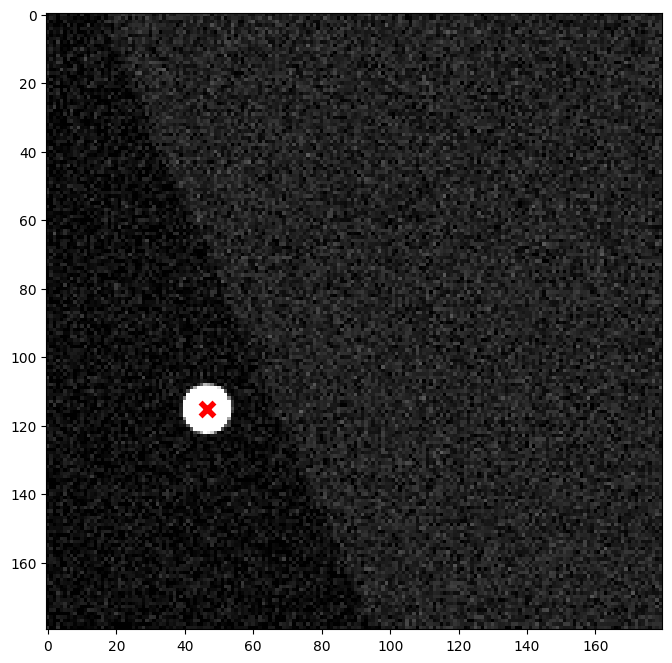

position: [ 46.54921848 115.09044995]/Image(array([ 46.54921848, 115.09044995])), gray_extent: None, cr_sigma: [6.94531871], gauss_amp: [4820.65259151], noise_sigma: [6.94531871]


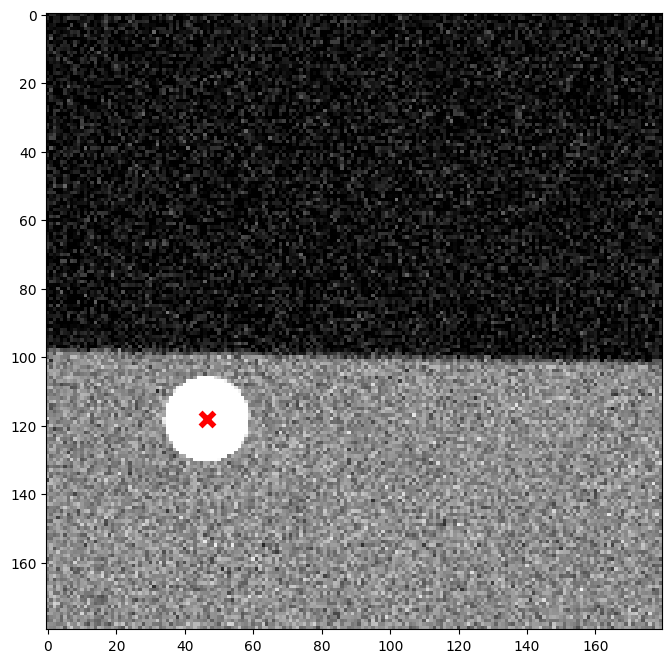

position: [ 46.4678424  118.13709363]/Image(array([ 46.4678424 , 118.13709363])), gray_extent: None, cr_sigma: [12.38683044], gauss_amp: [15336.01711951], noise_sigma: [12.38683044]


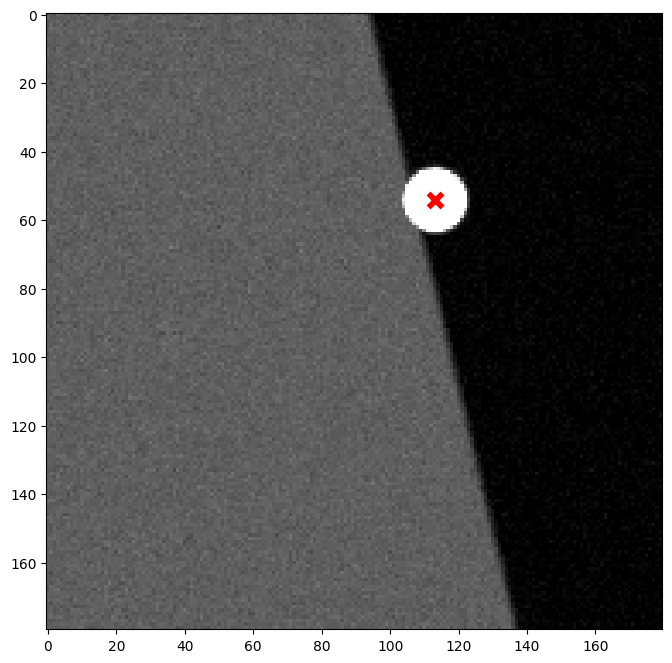

position: [113.16971669  54.13800142]/Image(array([113.16971669,  54.13800142])), gray_extent: None, cr_sigma: [9.11682431], gauss_amp: [2749.568432], noise_sigma: [9.11682431]


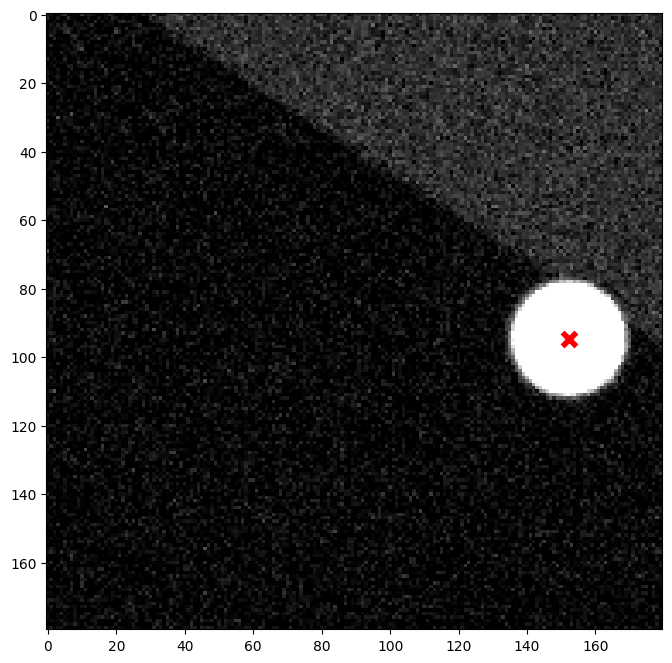

position: [152.272804    94.55596036]/Image(array([152.272804  ,  94.55596036])), gray_extent: None, cr_sigma: [16.33220719], gauss_amp: [839.24113119], noise_sigma: [16.33220719]


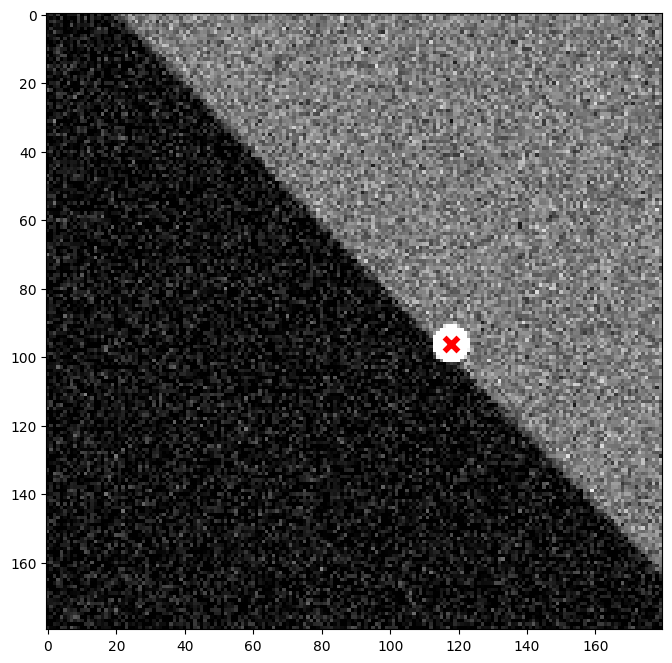

position: [117.8776558   96.13190967]/Image(array([117.8776558 ,  96.13190967])), gray_extent: None, cr_sigma: [5.44264112], gauss_amp: [19276.74326154], noise_sigma: [5.44264112]


In [6]:
def get_position(image):
    return np.array(image.get_property("position")) # I added back in the scaling.

# make data pipeline: image + labels
data_pipeline = image_pipeline & (image_pipeline >> get_position)

# test data pipeline
for p in range(5):
    output_image,position = data_pipeline.update()()
    plt.imshow(output_image, cmap='gray', vmin=0, vmax=1)
    plt.scatter(position[0], position[1], c="r", s=100, linewidths=4, marker="x")
    plt.show()

    print(f'position: {output_image.get_property("position")}/{position}, gray_extent: {output_image.get_property("extent")}, cr_sigma: {output_image.get_property("cr_sigma")}, gauss_amp: {output_image.get_property("gauss_amp")}, noise_sigma: {output_image.get_property("sigma")}')

## 2. Network training


In [ ]:
def scaled_pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1)))
def pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1))) * IMAGE_SIZE

In [ ]:
lr = 1e-4
# Building an optimiser
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=5000,
    decay_rate=0.6,
    staircase=True)

opt = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [ ]:
model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(64, 64, 128, 128, 256, 256, 512),
    dense_layers_dimensions=(64,32),
    steps_per_pooling=2,
    number_of_outputs=2,
    loss="mse",
    metrics=[pixel_error,scaled_pixel_error],
    optimizer= opt,
    flatten_method='global_max',
    dense_block=dt.layers.DenseBlock(activation="relu"),
    pooling_block=dt.layers.PoolingBlock(padding="valid"),
    output_kernel_size=3

)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      640       
                                                                 
 activation (Activation)     (None, 180, 180, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 180, 180, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                             

In [ ]:
# Define early-stopping:
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=40,
    mode='auto',
    restore_best_weights=True)

In [ ]:
# Function that retireves the position of a particle
# and divides it by Image size to get values between 0 and 1
def get_scaled_position_of_particle(image):
    return image.get_property("position") / IMAGE_SIZE

Generating 1006 / 1000 samples before starting training
Epoch 1/700
250/250 [==============================] - 37s 29ms/step - loss: 0.0465 - pixel_error: 42.5741 - scaled_pixel_error: 0.2365 - val_loss: 0.0214 - val_pixel_error: 31.8190 - val_scaled_pixel_error: 0.1768
Epoch 2/700
250/250 [==============================] - 7s 28ms/step - loss: 0.0072 - pixel_error: 17.0571 - scaled_pixel_error: 0.0948 - val_loss: 0.0064 - val_pixel_error: 16.5313 - val_scaled_pixel_error: 0.0918
Epoch 3/700
250/250 [==============================] - 6s 22ms/step - loss: 0.0040 - pixel_error: 12.7872 - scaled_pixel_error: 0.0710 - val_loss: 0.0033 - val_pixel_error: 10.6428 - val_scaled_pixel_error: 0.0591
Epoch 4/700
250/250 [==============================] - 7s 28ms/step - loss: 0.0025 - pixel_error: 10.0027 - scaled_pixel_error: 0.0556 - val_loss: 0.0016 - val_pixel_error: 6.4131 - val_scaled_pixel_error: 0.0356
Epoch 5/700
250/250 [==============================] - 6s 22ms/step - loss: 0.0013 - pix

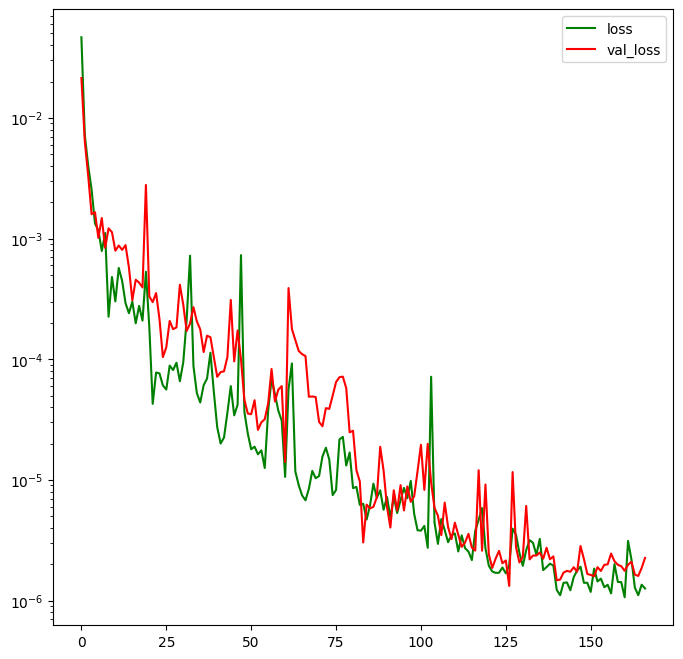

In [ ]:
validation_set_size = 300
validation_set    = [image_pipeline.update()() for _ in range(validation_set_size)]
validation_labels = [get_scaled_position_of_particle(image) for image in validation_set]

generator = dt.generators.ContinuousGenerator(
    image_pipeline,
    get_scaled_position_of_particle,
    min_data_size=int(1e3),
    max_data_size=int(2e4),
    batch_size=4,
    max_epochs_per_sample=1
)

with generator:
    # NB: this is a different run than the one reported in the paper
    h = model.fit(
        generator,
        validation_data=(
            np.array(validation_set),
            np.array(validation_labels)
        ),
        epochs=700,
            callbacks = EARLY_STOPPING,
            shuffle=True
    )

plt.plot(h.history["loss"], 'g')
plt.plot(h.history["val_loss"], 'r')
plt.legend(["loss", "val_loss"])
plt.yscale('log')
plt.show()

10/10 [==============================] - 0s 13ms/step


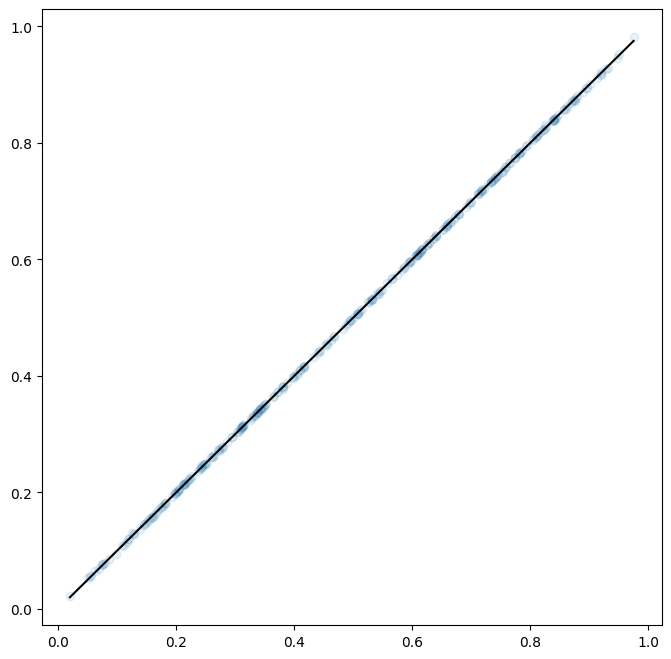

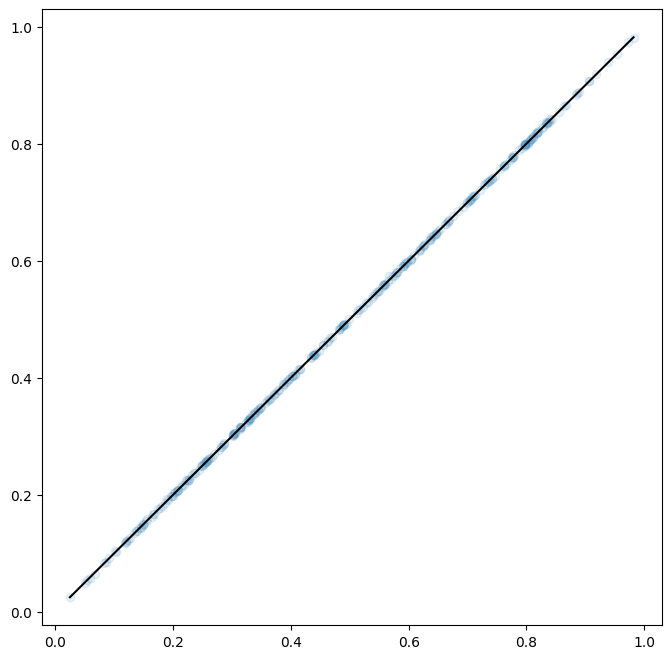

In [ ]:
validation_prediction = model.predict(np.array(validation_set))
labels = np.array(validation_labels)
for col in range(validation_prediction.shape[-1]):
    label_col = labels[:, col]
    prediction_col = validation_prediction[:, col]
    plt.scatter(label_col, prediction_col, alpha=0.1)

    plt.plot([np.min(label_col), np.max(label_col)],
             [np.min(label_col), np.max(label_col)], c='k')
    plt.show()

In [ ]:
# Model save
model.save('stage_1.h5')